In [83]:
import numpy as np
import pandas as pd
import re

In [101]:
from functools import reduce

In [13]:
with open('stage1-altitude.txt') as f:
    text = f.read()

# Pattern
```
'frame:0    pts:0       pts_time:0',
 'lavfi.ocr.text=',
```

In [78]:
def line_to_dict(line):
    elements = re.split('\s+', line.strip())
    frame_tuple = ('frame', elements[0])
    key_value_pairs = [tuple(re.split('[:=]', pair.strip())) for pair in elements[1:]]
    lengths = list(map(lambda tup: len(tup), key_value_pairs))
    if len(list(filter(lambda l: l < 2, lengths))) > 0:
        return {}
    else:
        return dict([frame_tuple] + key_value_pairs)

In [87]:
def get_dataframe_from_file(filename):
    with open(filename) as f:
        text = f.read()
    lines = text.split("frame:")
    parsed = [line_to_dict(l) for l in lines[1:-1]]
    df = pd.DataFrame(parsed)
    return df

In [89]:
stage_1_altitude = get_dataframe_from_file('stage1-altitude.txt')
stage_1_altitude

,frame,pts,pts_time,lavfi.ocr.text,lavfi.ocr.confidence
0,0,0,0,,NaN
1,1,2048,0.2,,NaN
2,2,4096,0.4,0.0,95
3,3,6144,0.6,0.0,95
4,4,8192,0.8,0.0,95
...,...,...,...,...,...
3034,3034,6213632,606.8,,NaN
3035,3035,6215680,607,,NaN
3036,3036,6217728,607.2,,NaN
3037,3037,6219776,607.4,,NaN


In [91]:
stage_1_speed = get_dataframe_from_file('stage1-speed.txt')
stage_1_speed

,frame,pts,pts_time,lavfi.ocr.text,lavfi.ocr.confidence
0,0,0,0,,NaN
1,1,2048,0.2,,NaN
2,2,4096,0.4,,NaN
3,3,6144,0.6,,NaN
4,4,8192,0.8,5,96
...,...,...,...,...,...
3034,3034,6213632,606.8,,NaN
3035,3035,6215680,607,,NaN
3036,3036,6217728,607.2,,NaN
3037,3037,6219776,607.4,,NaN


In [90]:
stage_2_altitude = get_dataframe_from_file('stage2-altitude.txt')
stage_2_altitude

,frame,pts,pts_time,lavfi.ocr.text,lavfi.ocr.confidence
0,0,0,0,,NaN
1,1,2048,0.2,,NaN
2,2,4096,0.4,,NaN
3,3,6144,0.6,,NaN
4,4,8192,0.8,,NaN
...,...,...,...,...,...
3034,3034,6213632,606.8,,NaN
3035,3035,6215680,607,,NaN
3036,3036,6217728,607.2,,NaN
3037,3037,6219776,607.4,33,0


In [92]:
stage_2_speed = get_dataframe_from_file('stage2-speed.txt')
stage_2_speed

,frame,pts,pts_time,lavfi.ocr.text,lavfi.ocr.confidence
0,0,0,0,,NaN
1,1,2048,0.2,,NaN
2,2,4096,0.4,,NaN
3,3,6144,0.6,2,0
4,4,8192,0.8,,NaN
...,...,...,...,...,...
3034,3034,6213632,606.8,.,0
3035,3035,6215680,607,,NaN
3036,3036,6217728,607.2,,NaN
3037,3037,6219776,607.4,,NaN


In [148]:
stage_1_h = stage_1_altitude.rename(columns={"lavfi.ocr.text": "stage_1_altitude"})
stage_2_h = stage_2_altitude.rename(columns={"lavfi.ocr.text": "stage_2_altitude"})
stage_1_v = stage_1_speed.rename(columns={"lavfi.ocr.text": "stage_1_speed"})
stage_2_v = stage_2_speed.rename(columns={"lavfi.ocr.text": "stage_2_speed"})

In [188]:
def clean_df(df):
    cleaned = df.set_index('pts_time').replace('', np.nan).apply(pd.to_numeric, errors="coerce").fillna(method="ffill").fillna(0.0)
    filtered = cleaned[cleaned['lavfi.ocr.confidence'] > 92]
    return filtered.drop(columns=['frame', 'pts', 'lavfi.ocr.confidence'])

In [229]:
s1_h = clean_df(stage_1_h)
s2_h = clean_df(stage_2_h)

altitude_dfs = [
    s1_h[s1_h["stage_1_altitude"] < 400],
    s2_h[s2_h["stage_2_altitude"] < 400]
]

data_frames = [
    clean_df(stage_1_v), 
    clean_df(stage_2_v), 
] + altitude_dfs


In [230]:
#data_frames = [stage_1_h, stage_1_v, stage_2_h, stage_2_v]

df_merged = reduce(lambda left,right: pd.merge(left,right,on=['pts_time'], how='left'), data_frames).replace('', np.nan)
df = df_merged.apply(pd.to_numeric, errors="coerce").fillna(method="ffill")
df

,stage_1_speed,stage_2_speed,stage_1_altitude,stage_2_altitude
pts_time,,,,
0.8,5.0,NaN,0.0,NaN
1,5.0,NaN,0.0,NaN
1.2,5.0,NaN,0.0,NaN
1.4,10.0,NaN,0.0,NaN
1.6,12.0,NaN,0.0,NaN
...,...,...,...,...
502.6,1.0,23611.0,0.0,167.0
502.8,1.0,23628.0,0.0,167.0
503,1.0,23654.0,0.0,167.0


In [231]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 9]

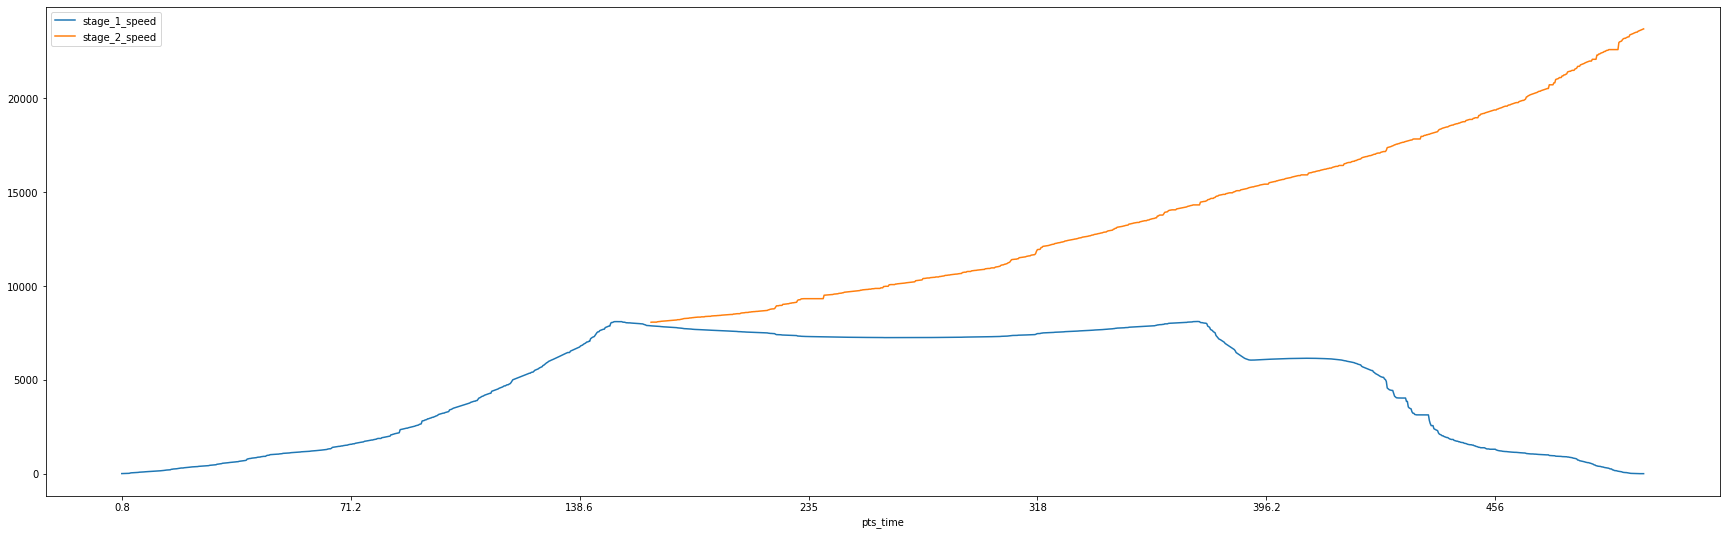

In [232]:
ax = df.plot(y='stage_1_speed')
df.plot(y="stage_2_speed", ax=ax)
plt.show()

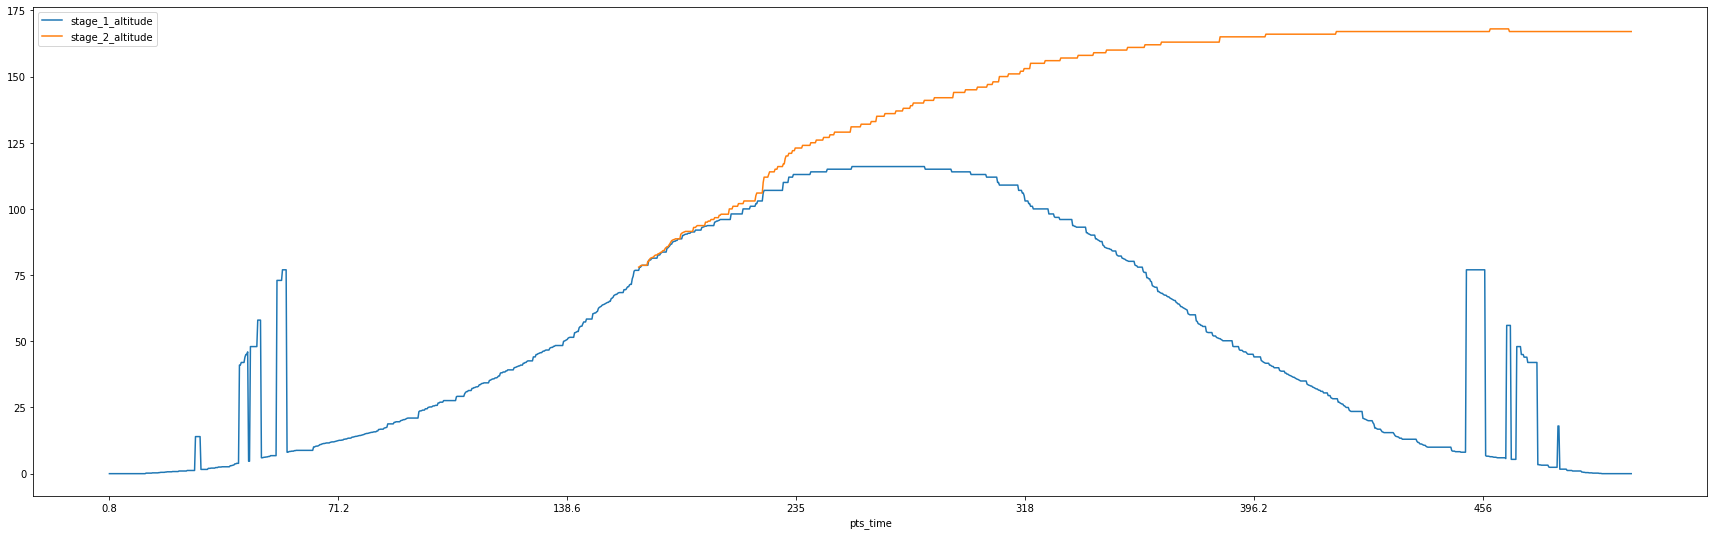

In [233]:
ax = df.plot(y='stage_1_altitude')
df.plot(y="stage_2_altitude", ax=ax)
plt.show()